## Tokenization


For transformers, a fundamental step is to convert the input text into a sequence of tokens. Tokenizers are used for this purpose. Different tokenization techniques can be used (e.g., Byte-Pair Encoding). 

These tokenizers need to be trained on some corpus (e.g., to figure out what the most common words are). However, the Hugging Face library provides pre-trained tokenizers that can be used out of the box.

Generally, each model has its own tokenizer. For example, the `BertTokenizer` is used for BERT models, and the `GPT2Tokenizer` is used for GPT-2 models. 


Since we will be using T5 for this exercise, we should be using the `T5Tokenizer` class. However, HuggingFace provides a common `AutoTokenizer` class that can be used to load the appropriate tokenizer for a given model  (do note, however, that the returned class will be the "correct" one!).

In [2]:
from transformers import AutoTokenizer

model_name = "google-t5/t5-base"
model_name = "t5-small"

tokenizer = AutoTokenizer.from_pretrained(model_name)
print(type(tokenizer))

from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

<class 'transformers.models.t5.tokenization_t5_fast.T5TokenizerFast'>


In [3]:
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

### Encoding/Decoding

Tokenization can be carried out by passing a string that we want to tokenize. The tokenizer implements the `__call__` method, so we can call the tokenizer directly, as follows.

Note that the output is a dictionary, which generally has the following keys:

- `input_ids`: The tokenized input text (a list of token IDs by default). 
- `attention_mask`: A mask that indicates which elements in the input text are tokens and which are padding tokens. For now, we can ignore this (there is no padding). It will instead become useful when we encode batches of sentences of different lengths at the same time.

In [2]:
sentence = "hello, this is a sentence!"
tokens = tokenizer(sentence)
print(tokens)

{'input_ids': [21820, 6, 48, 19, 3, 9, 7142, 55, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


We can reverse the encoding operation (i.e., going from token IDs to strings) by using the `decode` method of the tokenizer.

In [3]:
tokenizer.decode(tokens["input_ids"])

'hello, this is a sentence!</s>'

Note that we have an extra part at the end of the string, which is the special token `</s>`. This token is used to indicate the end of the input text (EOS). This token is automatically added by the tokenizer when encoding the input text.

To learn what the mapping between tokens and token IDs is, we can get the tokenizer's vocabulary (`.get_vocab()`), which provides the mapping between tokens and respective IDs. 

For convenience, we build also a reverse vocabulary (i.e., from IDs to tokens). 

In [4]:
import random 

vocabulary = tokenizer.get_vocab()
reverse_vocab = { v: k for k, v in vocabulary.items() }

vocab_keys = list(vocabulary.keys())


random.shuffle(vocab_keys)

# Show 10 random words from the vocabulary
{ k: vocabulary[k] for k in vocab_keys[:10] }

{'111': 15866,
 '▁bénéfici': 15972,
 '▁bin': 2701,
 'kot': 15414,
 'let': 1655,
 '▁Ausgangs': 29251,
 'HAR': 25430,
 'RM': 7336,
 '▁professor': 5812,
 '▁Expect': 19539}

In [5]:
print("Total vocabulary size:", len(vocabulary))

Total vocabulary size: 32100


We have a total of 32100. For T5, that's 32000 tokens + 100 special tokens (<extra_id_0>, <extra_id_1>, ..., <extra_id_99>) -- used for the tasks that T5 was trained on.

Let's see what the token id for the special token `</s>` is.

In [6]:
vocabulary["</s>"]

1

And indeed, note that our `tokens` has a 1 showing up at the end!

In [7]:
tokens["input_ids"]

[21820, 6, 48, 19, 3, 9, 7142, 55, 1]

We can include special tokens inside of the strings themselves. For instance:

In [8]:
tokenizer("hello!</s></s>")

{'input_ids': [21820, 55, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1]}

Here, we have 2 `</s>` tokens (the ones we specified), plus an additional one that was added by the tokenizer.

Instead of getting token IDs directly, we may look at the tokens being produced, directly. We use the `tokenize()` method in this case. 

In [9]:
tokenizer.tokenize(sentence)

['▁hello', ',', '▁this', '▁is', '▁', 'a', '▁sentence', '!']

What's up with those `_`? They simply represent words that are starting after spaces. This helps us understand whether a token is being used at the beginning of a sentence, or if it's in the middle of a word.

In [10]:
print(tokenizer.tokenize("hello    ,world"))
print(tokenizer.tokenize("hello    , world"))

['▁hello', '▁', ',', 'world']
['▁hello', '▁', ',', '▁world']


In the above case, `_hello` is the token for the word "hello" at the beginning of the sentence. However, the word "world" is mapped to two different tokens, depending on whether there is a space before the word or not. 

Notice also how multiple spaces are compacted into a single one!

These are all tokenizer-specific details. The tokenizer is responsible for deciding how to tokenize the input text. You may observe different behaviors for different tokenizers.

### Special tokens

Each model typically has its own special tokens. Some are necessary for the training process, while others can be beneficial at inference time.

Special attributes are available in the tokenizer class to access these special tokens. Some examples are:

- `pad_token` is the token used for padding (as discussed later),
- `bos_token` and `eos_token` tokens are used to indicate the beginning and end of the input text, respectively,
- `mask_token` is used for masking tokens during training (e.g., for the masked LM task, with BERT),
- `sep_token` is used to separate sentences in the input text (e.g., next sentence prediction, with BERT),
- `cls_token` is used to indicate the beginning of the input text (e.g., for classification tasks, with BERT),
- `unk_token` is used to indicate unknown tokens (i.e., tokens that are not in the vocabulary).

Of course, not all tokenizers will use all tokens. So those attributes will be set to None, if not used.

For instance, T5 has EOS and PAD tokens, but no BOS token.

In [11]:
tokenizer.eos_token, tokenizer.pad_token, tokenizer.bos_token

('</s>', '<pad>', None)

The `_id` suffix is used to indicate the corresponding token ID (None if not applicable).

In [12]:
tokenizer.eos_token_id, tokenizer.pad_token_id, tokenizer.bos_token_id

(1, 0, None)

### Batch encoding/decoding

In general (especially at training time) we will want to encode multiple sentences at once (e.g., an entire batch of sentences).

We can pass a list of sentences to be encoded to the tokenizer. 

In [13]:
sentences = [
    "this is the first sentence",
    "instead, this is the second sequence!"
]
tokens = tokenizer(sentences)

for tok in tokens["input_ids"]:
    print(tok)

[48, 19, 8, 166, 7142, 1]
[1446, 6, 48, 19, 8, 511, 5932, 55, 1]


Of course, sentences of different lengths have a different number of tokens! However, tensors (that will be used by the model) need to have the same number of elements along each dimension. 

To do this, we can use padding: all sentences will be padded to the length of the longest sentence in the batch. This is done by adding `pad` tokens (`<pad>`, for T5). 

However, since the pad tokens are not part of the input text, we need to let the model know that it should not pay attention to them. That's what the `attention_mask` is for! 

In [14]:
tokens = tokenizer(sentences, padding=True)

for tok, att in zip(tokens["input_ids"], tokens["attention_mask"]):
    print(tok, att)

[48, 19, 8, 166, 7142, 1, 0, 0, 0] [1, 1, 1, 1, 1, 1, 0, 0, 0]
[1446, 6, 48, 19, 8, 511, 5932, 55, 1] [1, 1, 1, 1, 1, 1, 1, 1, 1]


The first sentence is padded to the same length as the second sentence, with 0's (remember, the ID for `<pad>`!). 

The attention mask for the first sentence also contains 0's for the padding tokens: the model will ignore them when processing the input text.

Since now all sentences have the same length, we can stack them into a single tensor. Luckily, the tokenizer can already do this for us, we just need to ask. 


In [15]:
# note: we pass return_tensors="pt" to get PyTorch tensors
# (the library also supports TensorFlow tensors, but we
# don't care about them!)
tokens = tokenizer(sentences, padding=True, return_tensors="pt")
print(tokens["input_ids"])
print(tokens["attention_mask"])
print(tokens["input_ids"].shape)

tensor([[  48,   19,    8,  166, 7142,    1,    0,    0,    0],
        [1446,    6,   48,   19,    8,  511, 5932,   55,    1]])
tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]])
torch.Size([2, 9])


For completeness, we can also decode batches of sentences, with `tokenizer.batch_decode()`.

In [16]:
tokenizer.batch_decode(tokens["input_ids"])

['this is the first sentence</s><pad><pad><pad>',
 'instead, this is the second sequence!</s>']

## Model analysis

Now we can go ahead and finally load our T5 model. We once again use a pretrained version available on HuggingFace. 

In general, we could use the `AutoModel` class for the loading, of the model. However, that version of the model does not include the specific heads for the tasks that T5 was trained on.

The transformers library can make our life easier by defining a family of `AutoModel...` classes. 

For instance, the following are some commonly adopted classes:
- `AutoModel`: the base class for all models,
- `AutoModelForSequenceClassification`: a model for sequence classification tasks. It consists of a base model plus a classification head (linear layer + softmax). Note that, generally, the classification head is initialized randomly, and it needs to be trained on the specific task (but the library will let you know with a warning),
- `AutoModelForCaualLM`: a model for causal language modeling tasks (e.g., GPT-2), where we generate the output tokens one by one,
- `AutoModelForMaskedLM`: a model for masked language modeling tasks (e.g., BERT), where we predict the masked tokens in the input text,
- `AutoModelForTokenClassification`: a model for token classification tasks (e.g., NER), where we classify each token in the input text.
- `AutoModelForSeq2SeqLM`: a model for sequence-to-sequence tasks (e.g., T5), where we generate the output tokens one by one in an autoregressive manner, conditioned on the input sequence.

In our specific case, we will use the `AutoModelForSeq2SeqLM` class to be able to generate new tokens. 

In [17]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
print(type(model))

<class 'transformers.models.t5.modeling_t5.T5ForConditionalGeneration'>


To better understand the model, we can take a look at the model's configuration. The configuration contains all the hyperparameters of the model. The configuration is available as a dictionary, and we can access the values by using the attribute notation.

You can find the model's configuration object in the `config` attribute of the model. Or, if you only need the configuration, you can directly load it using the `AutoConfig` class.

```python
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_name)
```

In [18]:
model.config

T5Config {
  "_name_or_path": "google-t5/t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length"

Lots of information going on here. We can just take a few key aspects:

- `d_kv` = 64. This is the dimension of keys $d_k$ (so also queries) and values $d_v$ in the attention mechanism. It is common, to keep things simple, to use the same number of dimensions for keys, queries, and values (even though this is not strictly necessary). 
- `d_model` = 768. This is the dimension of the output of each transformer block.
- `d_ff` = 3072. This is the dimension of the feedforward network in each transformer block. We will see that the feedforward network is composed of two linear layers with a ReLU activation in between (`d_model -> d_ff -> d_model`).
- `num_layers` = 12. This is the number of transformer blocks in the model (both encoder and decoder).
- `num_heads` = 12. This is the number of attention heads in the multi-head attention mechanism. Each head will produce a different representation of the input text, and the results will be concatenated together. Remember that the output of each attention head is concatenated. We have 12 heads, each producing a 64-dimensional output, so the final output will be 12 * 64 = 768-dimensional.

We can now inspect the model to better understand its architecture.

In [19]:
model.encoder

T5Stack(
  (embed_tokens): Embedding(32128, 768)
  (block): ModuleList(
    (0): T5Block(
      (layer): ModuleList(
        (0): T5LayerSelfAttention(
          (SelfAttention): T5Attention(
            (q): Linear(in_features=768, out_features=768, bias=False)
            (k): Linear(in_features=768, out_features=768, bias=False)
            (v): Linear(in_features=768, out_features=768, bias=False)
            (o): Linear(in_features=768, out_features=768, bias=False)
            (relative_attention_bias): Embedding(32, 12)
          )
          (layer_norm): T5LayerNorm()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): T5LayerFF(
          (DenseReluDense): T5DenseActDense(
            (wi): Linear(in_features=768, out_features=3072, bias=False)
            (wo): Linear(in_features=3072, out_features=768, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
            (act): ReLU()
          )
          (layer_norm): T5LayerNorm()
          (d

We see that the model has a `shared` Embedding layer, an `encoder` and a `decoder`, and a final `lm_head`.

We can look into the token embedding first.


### Tokens embedding


In [20]:
model.shared

Embedding(32128, 768)

First, we can verify that this `shared` embedding layer, as the name suggests, is shared between the encoder and the decoder.

We do so by checking the id of the embedding layer with the embedding layers found in the encoder and decoder (`model.encoder.embed_tokens` and `model.decoder.embed_tokens`).

In [21]:
id(model.shared) == id(model.encoder.embed_tokens) and id(model.shared) == id(model.decoder.embed_tokens)

True

Next, we note that the embedding layer has 32128 tokens. 

This is not exactly the number of tokens we saw before (32100). The extra 28 tokens are "leftovers". 32128 = 251 * 128 is a more "GPU friendly" number, and it's used to speed up the computation (same reason why we often see batch sizes that are powers of 2).

In [22]:
words = [
    "chair",
    "table",
    "plate",
    "knife",
    "spoon",
    "horse",
    "goat",
    "sheep",
    "cat",
    "dog",
]

In [23]:
word_tokens = tokenizer(words, return_tensors="pt", padding=True)["input_ids"][:, 0]
print(word_tokens)
token_embeddings = model.shared(word_tokens).cpu().detach().numpy()
print(token_embeddings.shape)

tensor([ 3533,   953,  3829, 10821, 14987,  4952, 18174, 15184,  1712,  1782])
(10, 768)


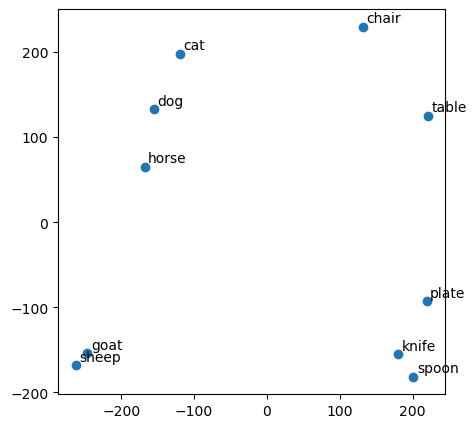

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(token_embeddings)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X_pca[:, 0], X_pca[:, 1])
for i, word in enumerate(words):
    ax.text(X_pca[i, 0]+5, X_pca[i, 1]+5, word)

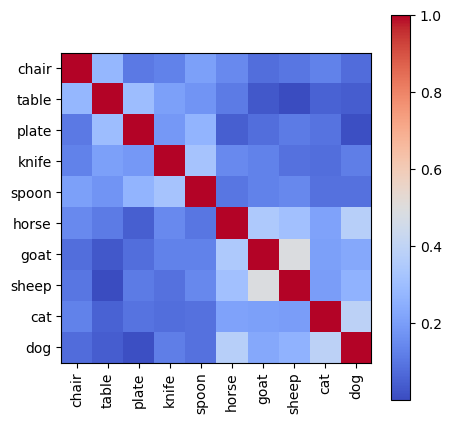

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(token_embeddings)
fig, ax = plt.subplots(figsize=(5,5))
cax = ax.imshow(cosine_similarity(token_embeddings), cmap="coolwarm")
fig.colorbar(cax)
plt.xticks(range(len(words)), words, rotation=90)
plt.yticks(range(len(words)), words);

### Encoder


The model's encoder contains various transformer layers (each one attention, feed-forward, and normalization layers).

In [26]:
model.encoder

T5Stack(
  (embed_tokens): Embedding(32128, 768)
  (block): ModuleList(
    (0): T5Block(
      (layer): ModuleList(
        (0): T5LayerSelfAttention(
          (SelfAttention): T5Attention(
            (q): Linear(in_features=768, out_features=768, bias=False)
            (k): Linear(in_features=768, out_features=768, bias=False)
            (v): Linear(in_features=768, out_features=768, bias=False)
            (o): Linear(in_features=768, out_features=768, bias=False)
            (relative_attention_bias): Embedding(32, 12)
          )
          (layer_norm): T5LayerNorm()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): T5LayerFF(
          (DenseReluDense): T5DenseActDense(
            (wi): Linear(in_features=768, out_features=3072, bias=False)
            (wo): Linear(in_features=3072, out_features=768, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
            (act): ReLU()
          )
          (layer_norm): T5LayerNorm()
          (d

The `block` attribute is a list of `T5Block` modules, and contains the actual transformer layers. Indeed, we can check (as previously stated) that we have 12 encoder layers in the encoder. 

In [27]:
model.encoder.block[0]

T5Block(
  (layer): ModuleList(
    (0): T5LayerSelfAttention(
      (SelfAttention): T5Attention(
        (q): Linear(in_features=768, out_features=768, bias=False)
        (k): Linear(in_features=768, out_features=768, bias=False)
        (v): Linear(in_features=768, out_features=768, bias=False)
        (o): Linear(in_features=768, out_features=768, bias=False)
        (relative_attention_bias): Embedding(32, 12)
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): T5LayerFF(
      (DenseReluDense): T5DenseActDense(
        (wi): Linear(in_features=768, out_features=3072, bias=False)
        (wo): Linear(in_features=3072, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (act): ReLU()
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)

In [28]:
len(model.encoder.block)

12

Each of the modules inside of the `block` is composed of a `T5LayerSelfAttention` module (attention layer), followed by a `T5LayerFF` module (feed-forward layer).

Remember that there are some other details (e.g., normalization layers, or dropouts) that are shown below, but we will not discuss them in detail here.

As a reminder, this is the architecture of a single encoder block. 

![encoder.png](images/encoder.png)

In [29]:
print(len(model.encoder.block), "\n\n", model.encoder.block[0]) 

12 

 T5Block(
  (layer): ModuleList(
    (0): T5LayerSelfAttention(
      (SelfAttention): T5Attention(
        (q): Linear(in_features=768, out_features=768, bias=False)
        (k): Linear(in_features=768, out_features=768, bias=False)
        (v): Linear(in_features=768, out_features=768, bias=False)
        (o): Linear(in_features=768, out_features=768, bias=False)
        (relative_attention_bias): Embedding(32, 12)
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): T5LayerFF(
      (DenseReluDense): T5DenseActDense(
        (wi): Linear(in_features=768, out_features=3072, bias=False)
        (wo): Linear(in_features=3072, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (act): ReLU()
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)


Notice that the $W_q$, $W_k$, and $W_v$ matrices are 768x768. But, we stated that each attention is 64-dimensional, so they should be 768x64!

However, remember that we have 12 heads: instead of producing 12 different heads, we instead efficiently represent all matrices inside of a single matrix. In addition, there is no need for concatenating the results: the output will already be the concatenation of all heads.

The $W_o$ matrix is 768x768, i.e. `d_kv`*`num_heads` x `d_model`, as expected.

### Decoder

We can inspect the decoder in the same way. Remember the decoder's architecture!

![decoder.png](images/decoder.png)

In [30]:
model.decoder.block[0]

T5Block(
  (layer): ModuleList(
    (0): T5LayerSelfAttention(
      (SelfAttention): T5Attention(
        (q): Linear(in_features=768, out_features=768, bias=False)
        (k): Linear(in_features=768, out_features=768, bias=False)
        (v): Linear(in_features=768, out_features=768, bias=False)
        (o): Linear(in_features=768, out_features=768, bias=False)
        (relative_attention_bias): Embedding(32, 12)
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): T5LayerCrossAttention(
      (EncDecAttention): T5Attention(
        (q): Linear(in_features=768, out_features=768, bias=False)
        (k): Linear(in_features=768, out_features=768, bias=False)
        (v): Linear(in_features=768, out_features=768, bias=False)
        (o): Linear(in_features=768, out_features=768, bias=False)
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): T5LayerFF(
      (DenseReluDense): T5DenseA

Indeed, we find the expected architecture. 

An initial self-attention module, followed by a multi-head attention one (`T5LayerCrossAttention`), and finally a feed-forward module.

Note that, although there is a dedicated class for cross-attention, the module still makes use of the same `T5Attention` class we also used for self-attention. This is because nothing changes in the attention mechanism itself: only the inputs are different.

Finally, note that the model's `lm_head` is a linear layer that takes the output of the decoder (768-dimensional) and maps it to the vocabulary size (32128).

In [31]:
model.lm_head

Linear(in_features=768, out_features=32128, bias=False)

## Token generation

Let's now focus on the token generation process.

Remember, we are working with an encoder-decoder architecture. The encoder processes the input text, and the decoder generates the output text.

The input for the encoder is the tokenized input text. We also need to specify an input for the decoder. The decoder's input will be the currently generated sequence thus far. For the first iteration, there is nothing already generated, so we need to specify a special token to indicate the beginning of the sequence (BOS). For T5, the token will be `<pad_token>`. 

In [32]:
import torch

input_sentence = "translate english to german: hello, how are you?"

tokens = tokenizer(input_sentence, return_tensors="pt")

decoder_input_ids = torch.tensor([[ tokenizer.pad_token_id ]])

In [33]:
print("Encoder's input")
print(tokens["input_ids"])

print()
print("Decoder's input")
print(decoder_input_ids)

Encoder's input
tensor([[13959, 22269,    12, 13692,    10, 21820,     6,   149,    33,    25,
            58,     1]])

Decoder's input
tensor([[0]])


To generate the first output token (after `<pad_token>`), we call the model's __call__ method (or `forward` method) with the input text and the decoder's input.

In [34]:
# **tokens passes the dictionary as keyword arguments (input_ids=..., attention_mask=...)
output = model(**tokens, decoder_input_ids=decoder_input_ids)
print(output.keys())

odict_keys(['logits', 'past_key_values', 'encoder_last_hidden_state'])


In [35]:
output["past_key_values"][0]

(tensor([[[[ 8.0751e-01,  5.9590e-01, -4.6880e-01,  4.9266e-01,  1.1197e+00,
            -1.2452e+00, -9.0581e-01, -5.2789e-01,  3.6213e-01,  3.6954e-01,
            -4.3455e-02, -8.5433e-01, -6.6289e-01, -4.9530e-02,  5.1809e-01,
            -8.5448e-01, -4.5317e-01,  5.9210e-01, -2.5630e-01,  9.7839e-04,
            -5.9754e-01, -1.8106e+00, -1.5930e+00,  5.2041e-01, -3.8632e-01,
             4.0855e-01,  1.7834e+00,  4.0360e-01, -1.1653e+00, -5.5640e-01,
            -5.5420e-01,  4.8449e-01, -5.6703e-01,  4.0686e-01, -1.3294e+00,
            -4.6914e-01,  4.6921e-01, -3.6158e-01,  5.2256e-01, -3.2758e-01,
             3.6369e-01, -1.1385e-01,  4.4046e-01, -1.8292e-01, -4.6193e-01,
             2.3514e-02,  1.1758e-01, -5.2525e-01, -5.6002e-01, -7.8300e-01,
             2.6148e-01, -2.4737e+00,  4.7007e-01, -2.6592e-01, -1.5485e+00,
             3.2745e+00,  9.0812e-01,  7.0409e-01, -2.0157e-02, -8.3044e-02,
             6.8403e-01, -7.7884e-01,  5.1766e-01, -3.4012e-01]],
 
        

We get three outputs:

- `logits`: The logits for each token in the vocabulary. The logits are the output of the linear layer (the `lm_head`) that maps the decoder's output to the vocabulary size. The logits are used to compute the probabilities of each token.

- `past_key_values`: The past key-values of the decoder. This is used to speed up the generation process for future tokens. Remember: the decoder is autoregressive, so we generate one token at a time. Since each token can only pay attention to past tokens, it means that the predictions made for earlier tokens will not change. Thus, we can cache them and not re-compute them. So, if we pas `past_key_values` to the model the next time we call it, it will be faster.

- `encoder_last_hidden_state`: The hidden states of the last layer of the encoder (also this one remains always the same during the generation!). This is not used for generating the next token, but we may find it useful for other tasks (e.g., summarization).

In [36]:
print(output.logits.shape)

torch.Size([1, 1, 32128])


The shape of the logits is 1x1x32128. The first dimension is the batch size, the second dimension is the number of tokens in the output sequence (we are still at a single generated token), and the third dimension is the number of tokens in the vocabulary.

So what's the next word going to be? We can use greedy decoding to take the token with the highest probability.

In [37]:
output.logits[0,0].argmax()

tensor(2501)

In [38]:
max_proba_token = output.logits[0,0].argmax()
print("Max probability token:", max_proba_token.item())
print("Corresponding token:", tokenizer.decode(max_proba_token))

Max probability token: 2501
Corresponding token: Hall


Looks like we're on the right track. We have a new token, which we can add to our `decoder_input_ids` tensor and continue with the next iteration.


In [39]:
# .view() acts like .reshape(), but assumes that the tensor is contiguous in memory (& is faster)
decoder_input_ids = torch.hstack([decoder_input_ids, max_proba_token.view(1, 1)])
print(decoder_input_ids)

tensor([[   0, 2501]])


In [40]:
output = model(**tokens, decoder_input_ids=decoder_input_ids)
output.logits.shape

torch.Size([1, 2, 32128])

Now the output has shape 1x2x32128. We have generated two tokens! 

The first one, remember, will necessarily be the same as the one we produced before, since the masking mechanism prevents the model from seeing any following token. 

But just to be sure, let's decode both tokens. 

In [41]:
# 0 -> first (and only) batch
max_proba_tokens = output.logits[0].argmax(axis=1)
print("Token ids", max_proba_tokens)
print("Mapped tokens", list(map(reverse_vocab.get, max_proba_tokens.tolist())))
print("Decoded string", tokenizer.decode(max_proba_tokens))

Token ids tensor([2501,   32])
Mapped tokens ['▁Hall', 'o']
Decoded string Hallo


We are onto something. We could go ahead and generate more tokens manually. 

In [42]:

decoder_input_ids = torch.tensor([[ tokenizer.pad_token_id ]])

max_length = 50
i = 0

while i < max_length and decoder_input_ids[0,-1] != tokenizer.eos_token_id:
    output = model(**tokens, decoder_input_ids=decoder_input_ids)
    max_proba_tokens = output.logits[0].argmax(axis=1)
    print(f"Step {i+1}: {tokenizer.decode(max_proba_tokens)}")
    decoder_input_ids = torch.hstack([decoder_input_ids, max_proba_tokens[-1].view(1, 1)])
    i += 1

Step 1: Hall


Step 2: Hallo
Step 3: Hallo,
Step 4: Hallo, wie
Step 5: Hallo, wie sind
Step 6: Hallo, wie sind Sie
Step 7: Hallo, wie sind Sie?
Step 8: Hallo, wie sind Sie?</s>


Note that we are introducing a `max_length` parameter. This is just in case, to prevent the model from generating an infinite sequence.

Now, turns out that the model has a `generate()` method that does exactly what we just did.

In [43]:
out_tokens = model.generate(**tokens, max_length=max_length)
tokenizer.batch_decode(out_tokens)

['<pad> Hallo, wie sind Sie?</s>']

You may also empirically verify that `model.generate()` is faster than the manual loop. This is because there are some optimizations in the `generate()` method that make the generation process faster (e.g., caching the encoder's outputs, or the previous decoder's hidden states). 

## Cross-attention_

We can now run the previous code, but now let's compute the cross-attention weights. This will help us understand what the model is paying attention to in the input sequence, when generating the next token.

To compute the attention weights, we need to reload the model, passing the `output_attentions=True` parameter. This will make the model return the attention weights for each layer.

In [44]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, output_attentions=True)

/home/csavelli/llm/.conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


In [45]:
# re-prepare encoder tokens and decoder tokens
# input_sentence = "translate from english to german: hello how are you?"
input_sentence = "translate english to german: hello how are you?"
tokens = tokenizer(input_sentence, return_tensors="pt")
decoder_input_ids = torch.tensor([[ tokenizer.pad_token_id ]])

output = model(**tokens, decoder_input_ids=decoder_input_ids)
print(output.keys())

odict_keys(['logits', 'past_key_values', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state', 'encoder_attentions'])


In [46]:
tokenizer.batch_decode(model.generate(**tokens, decoder_input_ids=decoder_input_ids))

/home/csavelli/llm/.conda/lib/python3.11/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['<pad> Hallo, wie sind Sie?</s>']

In addition to the previous values, we now have `decoder_attentions`, `cross_attentions`, and `encoder_attentions`.

The names are self-explanatory. We will focus on the cross-attention to understand encoder-decoder interactions.

Each of the decoder's layers has a corresponding cross-attention layer. So we expect to have 12 cross-attention layers. Indeed, the `cross_attention` is a tuple, with 12 elements.

In [47]:
type(output.cross_attentions), len(output.cross_attentions)

(tuple, 12)

The shape of any one of these attentions is the following: 1x12x1x13. Remember:

- the first 1 is the batch size (a single sentence),
- 12 are the attention heads, each one producing an attention mask,
- 1 is the number of tokens passed as input to the decoder (just BOS, for now),
- 11 is the number of tokens in the input sequence.

In [48]:
output.cross_attentions[0].shape

torch.Size([1, 12, 1, 11])

Let's look at the first layer's attentions. 

We can see that for early stages the attention is mostly focused on identifying the task ("translate", "english", "german").

Interestingly, "german" gets attention from many of the heads, whereas "translate" and "english" are less attended to. We can expect this to be the case since T5 has been trained on various tasks, one of which was translation from english to other languages. 

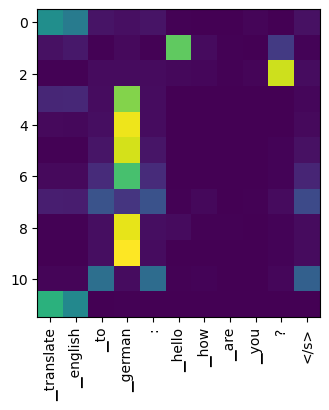

In [52]:
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(output.cross_attentions[0][0, :, 0].detach().numpy())
input_tokens = tokenizer.tokenize(input_sentence) + [ "</s>" ]
ax.set_xticks(range(len(input_tokens)), input_tokens, rotation=90);

We can check the rest of the attentions in the other layers as well. 

With the exception of the initial layer, the attention on "translate" and "english" is mostly gone. The attention is now focused on "german" and on the first word of the sentence ("hello"). 


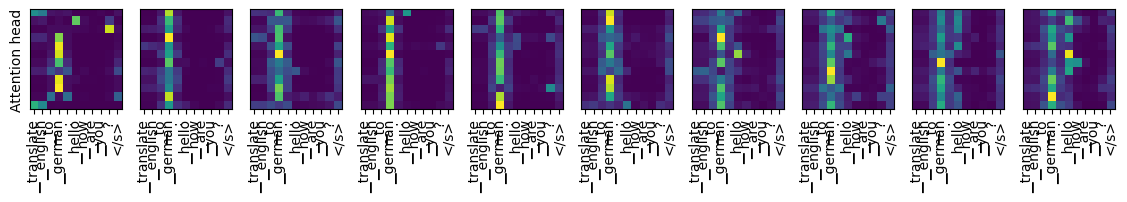

In [53]:
fig, ax = plt.subplots(1, 10, figsize=(14, 3))

ax[0].set_ylabel("Attention head")

for i in range(10):
    ax[i].imshow(output.cross_attentions[i][0, :, 0].detach().numpy())
    input_tokens = tokenizer.tokenize(input_sentence) + [ "</s>" ]
    ax[i].set_xticks(range(len(input_tokens)), input_tokens, rotation=90);
    ax[i].set_yticks([])

As a final exploration, let's check the average attention across layers and heads, for the last token generated throughout the entire sequence. 

In this way, we can observe how the attention shifts as we generate more tokens.

In [54]:
decoder_input_ids = torch.tensor([[ tokenizer.pad_token_id ]])

attns = []

max_length = 50
i = 0

while i < max_length and decoder_input_ids[0,-1] != tokenizer.eos_token_id:
    output = model(**tokens, decoder_input_ids=decoder_input_ids)
    max_proba_tokens = output.logits[0].argmax(axis=1)
    print(f"Step {i+1}: {tokenizer.decode(max_proba_tokens)}")
    decoder_input_ids = torch.hstack([decoder_input_ids, max_proba_tokens[-1].view(1, 1)])
    attns.append(output.cross_attentions)
    i += 1

Step 1: Hall
Step 2: Hallo
Step 3: Hallo,
Step 4: Hallo, wie
Step 5: Hallo, wie sind
Step 6: Hallo, wie sind Sie
Step 7: Hallo, wie sind Sie?
Step 8: Hallo, wie sind Sie?</s>


Note: taking the average across all heads and all layers may not necessarily be the best approach (for instance, some interesting aspects may be lost in this aggregation). However, it should give us a general idea of what the model is focusing on.

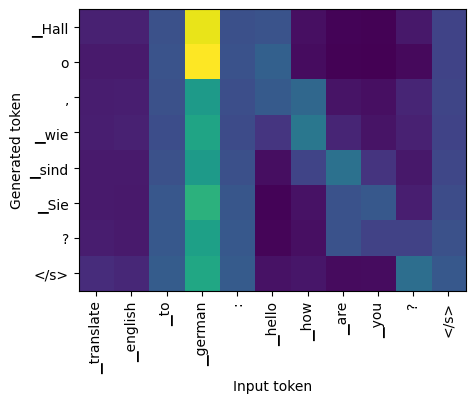

In [55]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(torch.stack([ torch.stack(a).mean(axis=(0, 1, 2))[-1] for a in attns ]).detach().numpy())
ax.set_xlabel("Input token")
ax.set_ylabel("Generated token")

input_tokens = tokenizer.tokenize(input_sentence) + [ "</s>" ]
output_tokens = tokenizer.tokenize(tokenizer.decode(output.logits[0].argmax(axis=1)))
ax.set_xticks(range(len(input_tokens)), input_tokens, rotation=90)
ax.set_yticks(range(len(output_tokens)), output_tokens);

Indeed, when Hall|o|, is generated, the most attention is paid to the word "hello". Then the attention shifts to the rest of the sentence gradually. This shows how the decoder can focus on different parts of the input sequence as it generates different parts of the output sequence!